# Sleep Prediction
Here we try to use environemntal parameter in addition to mood characteristics to see if we are able to predict sleep quality.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ and mood data.

### Fitbit Sleep Summary

In [3]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)#,index_col=["beiwe","start_time"])
for stage in ["rem","nrem"]:
    fb_sleep[f"{stage}_percent"] = fb_sleep[f"{stage}_minutes"] / (fb_sleep["tst_fb"]*60)
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,waso,rem_percent,nrem_percent
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,0.400000,297,0.276094,6.766667,12.18,0.201970,0.731527
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,0.171429,345,0.136232,8.216667,64.09,0.095335,0.699797
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,0.421053,237,0.210970,5.483333,16.45,0.151976,0.720365
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,0.423077,320,0.259375,7.450000,17.88,0.185682,0.715884
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,0.560000,263,0.334601,6.933333,33.28,0.211538,0.632212


### Self-Report Sleep

In [4]:
bw_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
bw_sleep["date"] = pd.to_datetime(bw_sleep["timestamp"].dt.date)
bw_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon,date
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0,2020-05-13
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0,2020-05-13
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0,2020-05-13
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN,2020-05-13
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN,2020-05-13


### Beacon IAQ
IAQ measurements courtesy of the beacons

In [5]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw.drop([c for c in ieq_raw.columns if c.endswith("percent") or c.endswith("mean")],axis="columns",inplace=True)
for bad_label in ["long","lat","accuracy","altitude","pm1","number"]:
    ieq_raw.drop([c for c in ieq_raw.columns if c.startswith(bad_label)],axis="columns",inplace=True)

ieq = ieq_raw.copy()
ieq["date"] = pd.to_datetime(ieq["end_time"].dt.date)
ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,date
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,33.0,91.90,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000,0.950,2020-08-10
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,34.0,160.45,0.204,NaN,5.565250,202.651343,6.086460,0.665257,1.650,2.000,2020-08-11
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,33.0,108.60,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000,1.500,2020-08-12
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,33.0,81.80,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175,1.250,2020-08-14
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,34.0,149.30,0.136,NaN,0.684917,125.544723,43.415611,2.880943,1.000,2.575,2020-08-15


### Beiwe Mood
Mood data as reported by participants on the EMAs.

In [6]:
bw_mood = pd.read_csv("../data/processed/beiwe-daily_ema-ux_s20.csv",parse_dates=["date","timestamp_morning","timestamp_evening"],infer_datetime_format=True)
bw_mood.head()

,timestamp_morning,beiwe,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,redcap,beacon,date,timestamp_evening,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,content_mean,stress_mean,lonely_mean,sad_mean,energy_mean
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0,2020-05-13,2020-05-13 21:00:18,3.0,1.0,0.0,0.0,4.0,3.0,0.5,0.0,0.0,2.5
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0,2020-05-13,2020-05-13 19:00:23,1.0,1.0,1.0,3.0,2.0,1.0,1.5,1.0,2.0,1.5
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0,2020-05-13,2020-05-13 20:07:04,1.0,3.0,1.0,2.0,0.0,1.0,2.0,1.0,2.5,0.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN,2020-05-13,2020-05-13 19:30:38,2.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.5,0.5
4,2020-05-13 12:30:38,lkkjddam,1,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0,12,21.0,2020-05-13,2020-05-13 19:21:32,0.0,2.0,3.0,1.0,0.0,0.0,1.5,3.0,2.0,1.0


# IEQ Clustering
It would be interesting to see if there are any clusters that arise from the data by looking at the median concentrations of a few pollutants

In [7]:
from sklearn.cluster import KMeans

## Getting Features for Cluster

In [8]:
X = ieq[[column for column in ieq.columns if column.endswith("median") and not column.startswith("no2")]]
X.dropna(inplace=True)
X_norm = (X-X.min())/(X.max()-X.min())

## Elbow Method for Determining k

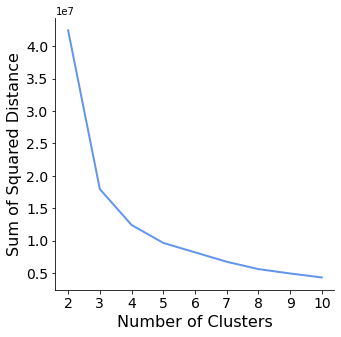

In [9]:
# getting sum of squared distance for different k
errors = []
for k in range(2,11,1):
    model = KMeans(n_clusters=k)
    model.fit(X)
    errors.append(model.inertia_)
    
# plotting
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(2,11,1),errors,linewidth=2,color="cornflowerblue")
## x-axis
ax.set_xlabel("Number of Clusters",fontsize=16)
plt.xticks(fontsize=14)
## y-axis
ax.set_ylabel("Sum of Squared Distance",fontsize=16)
plt.yticks(fontsize=14)
## remainder
for loc in ["top","right"]:
    ax.spines[loc].set_visible(False)
    
plt.show()
plt.close()

<div class="alert alert-block alert-success">
 
Looks like the optimal number of clusters is close to **3**.
    
</div>

## Creating the model

In [10]:
k=3
kmeans = KMeans(n_clusters=k)
cluster = kmeans.fit(X_norm)
for c in range(k):
    n_points = len(cluster.labels_[cluster.labels_ == c])
    print(f"Number of points in Cluster {c}: {n_points}")
X_norm["cluster"] = cluster.labels_

Number of points in Cluster 0: 117
Number of points in Cluster 1: 173
Number of points in Cluster 2: 25


## Checking Distributions of Features to Visually Inspect Clusters

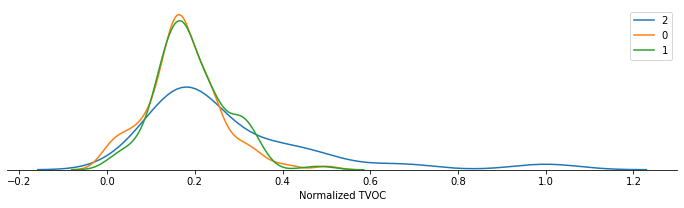

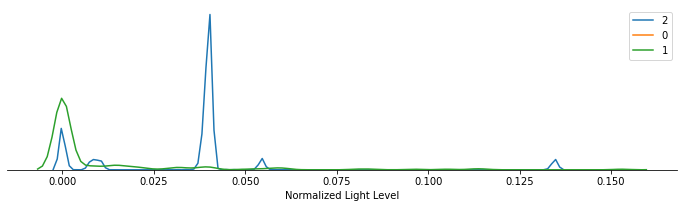

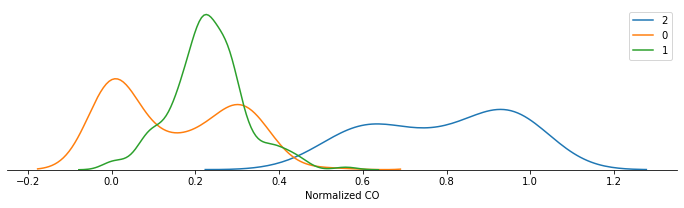

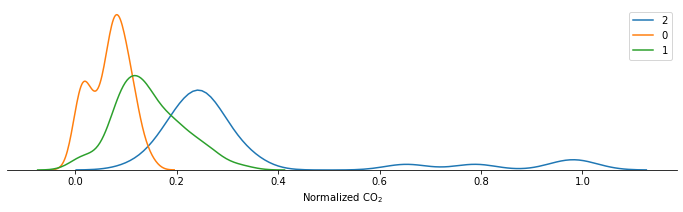

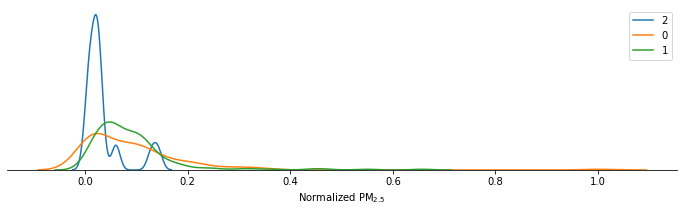

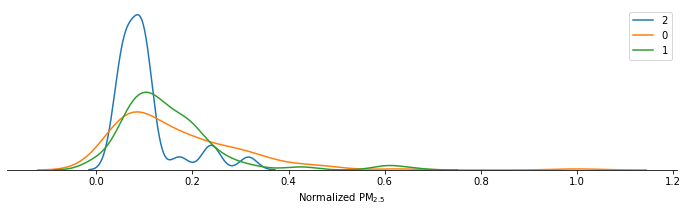

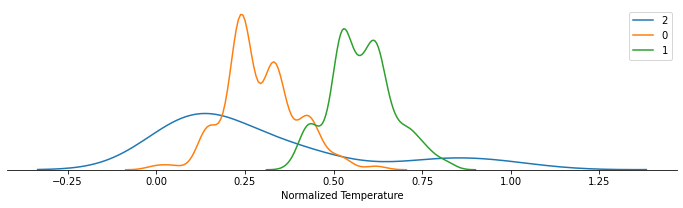

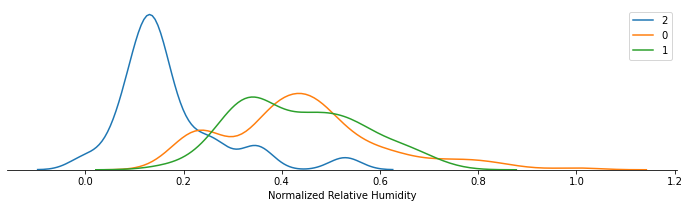

In [11]:
for var in X_norm.columns:
    if var not in ["cluster"]:
        fig, ax = plt.subplots(figsize=(12,3))
        for c in X_norm["cluster"].unique():
            to_plot = X_norm[X_norm["cluster"] == c]
            sns.kdeplot(to_plot[var],ax=ax,label=c)
        # improving graph
        for loc in ["left","top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_xlabel("Normalized " + visualize.get_pollutant_label(var.split("_median")[0]))
        ax.set_yticks([])
        
        plt.show()
        plt.close()

Looks like the following algorithm identified the clusters based on `temperature_c` measurements for the most part, but with some other considerations:

**0**: Largest cluster of 174 data points characterized by high `temperature_c` and typical `co2` and `co` concentrations.

**1**: Smallest cluster of 25 data points characterized by low `rh` and `temperature_c` and high `co2` and `co`.

**2**: Cluster of 116 datapoints with typical `temperature_c` and low `co2`. 

Some other important notes:
* The clusters seem to be nearly no weight on `tvoc` with all distributions peaking around 0.2 normalized TVOC.
* Similarly, little information can be gained from the `pm2p5` measurements.

# Predicting Restfulness from IEQ
We start with trying to predict `restfulness` by only considering the IEQ data from the BEVO Beacon.

## Creating the Dataset
We start by merging the Fitbit and GPS filtered IEQ data with the EMA data from Beiwe

In [12]:
bw_sleep_and_ieq = ieq.merge(right=bw_sleep,on=["beiwe","beacon","redcap","date"])
bw_sleep_and_ieq["restful_binary"] = [1 if score > 1 else 0 for score in bw_sleep_and_ieq["restful"]]
bw_sleep_and_ieq.drop(["no2_median","no2_delta","lux_median","lux_delta"],axis="columns",inplace=True)
bw_sleep_and_ieq.dropna(inplace=True)
bw_sleep_and_ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,date,timestamp,content,stress,lonely,sad,energy,tst,sol,naw,restful,restful_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,10.359917,1600.754959,0.914249,0.895571,23.337500,33.0,91.900000,0.731650,304.035761,1.960803,0.620298,1.000,0.950000,2020-08-10,2020-08-10 12:56:38,1,2.0,0.0,0.0,2.0,6.0,15.0,5.0,0.0,0
1,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,10.271850,1596.122408,2.879650,0.939256,24.000000,33.0,108.600000,0.512533,146.009840,5.472740,0.702017,0.000,1.500000,2020-08-12,2020-08-12 11:11:42,2,3.0,0.0,0.0,2.0,8.0,10.0,3.0,2.0,1
2,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,7.232700,1301.449844,1.232406,0.886675,25.000000,33.0,81.800000,5.108383,233.372161,3.742991,0.736714,1.175,1.250000,2020-08-14,2020-08-14 15:02:44,2,3.0,1.0,2.0,3.0,8.0,10.0,3.0,3.0,1
3,2020-08-16 04:21:30,2020-08-16 11:53:00,21,lkkjddam,25,12,268.650000,10.486333,1319.535880,1.256692,0.884277,24.000000,34.0,88.216667,0.312050,96.153213,3.655915,0.471061,0.500,0.583333,2020-08-16,2020-08-16 12:25:03,1,2.0,1.0,2.0,1.0,6.0,20.0,4.0,1.0,0
4,2020-08-17 03:00:00,2020-08-17 11:30:30,21,lkkjddam,25,12,327.166667,11.025200,1412.926806,2.952962,1.113030,23.333333,33.0,249.066667,0.819100,331.097623,7.407653,1.358703,1.750,1.500000,2020-08-17,2020-08-17 11:41:47,1,2.0,1.0,1.0,1.0,6.0,25.0,2.0,1.0,0


In [13]:
print("Number of observations:", len(bw_sleep_and_ieq))

Number of observations: 182


In [95]:
print("Number of `Positive` restfulness scores:", len(bw_sleep_and_ieq[bw_sleep_and_ieq["restful_binary"] == 1]))
print("Number of `Negative` restfulness scores:", len(bw_sleep_and_ieq[bw_sleep_and_ieq["restful_binary"] == 0]))

Number of `Positive` restfulness scores: 156
Number of `Negative` restfulness scores: 26


## Defining Features and Targets
The feature set will include all possible `median` and `delta` measurements for the pollutants while the target value will simply by the `restfulness` score.

In [14]:
features = bw_sleep_and_ieq[[column for column in bw_sleep_and_ieq.columns if column.endswith("median")]]
features.head()

,tvoc_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median
0,126.658333,10.359917,1600.754959,0.914249,0.895571,23.337500,33.0
1,252.016667,10.271850,1596.122408,2.879650,0.939256,24.000000,33.0
2,223.700000,7.232700,1301.449844,1.232406,0.886675,25.000000,33.0
3,268.650000,10.486333,1319.535880,1.256692,0.884277,24.000000,34.0
4,327.166667,11.025200,1412.926806,2.952962,1.113030,23.333333,33.0


In [15]:
target = bw_sleep_and_ieq[["restful_binary"]]
target.head()

,restful_binary
0,0
1,1
2,1
3,0
4,0


## Testing Different Models
Using `GridSearchCV`, we can see which models perform best.

The models we will test are:
* Multi-Layer Perceptron Neural Network
* Random Forest Classifier
* K-Nearest Neighbots Classifier

The associated models are imported below.

In [89]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Definining the Models' Parameters to Test
The following cell outlines the hyper-parameters that will be tested. The values have been tuned after a few iterations of `GridSearchCV`.

In [90]:
model_params = {
    "mlp": {
        "model":MLPClassifier(max_iter=10000,activation="logistic",solver="sgd"),
        "params": {
            "hidden_layer_sizes": [0,1,2,3,4],
        }
    },
    "random_forest": {
        "model":RandomForestClassifier(),
        "params": {
            "n_estimators":[15,20,25],
            "max_depth":[2,3,4],
        }
    },
    "knn": {
        "model":KNeighborsClassifier(),
        "params": {
            "n_neighbors":[3,5,7],
        }
    }
}

### Splitting the Data
The features and targets are split and stratified to preserve the proportion of `positive` and `negative` `restfulness` scores. This stratification seemed important since there are fewer `negative` scores relative to `positive`. 

In [86]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
# getting training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=10, stratify=target)

### Grid Search
Now we run the `GridSearchCV` to understand how we can fine-tune some of the more imiportant parameters defined earlier.

In [87]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        "model":model_name,
        "best_score":clf.best_score_,
        "best_params":clf.best_params_
    })
    
results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
results

<div class="alert alert-block alert-success">
 
While there were iterations where the random forest model performed better, the MLP NN was consistent with its results and therefore will be the model that we explore further.
    
</div>

## Multilayer Perceptron NN Classifier
Here we use a MLP classifier to understand how well we can predict the restfulness score from IEQ parameters experienced during the night. More on the MLP classifier can be found on SKlearn's documentation:
* [General Discussion on MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
* [MLP Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [53]:
from sklearn import metrics

In [66]:
class restful_mlp():
    def __init__(self, features, target):
        self.X = features
        self.y = target
        
    def split_data(test_size=0.33):
        pass
        
    def fit_model(self):
        pass
    
    def confusion_matrix(self,y_true,y_pred):
        """plots confusion matrix"""
        # get confusion matrix
        cm = metrics.confusion_matrix(y_true,y_pred)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_xticklabels(["Negative","Positive"],fontsize=14)
        ax.set_ylabel("True Label",fontsize=16)
        ax.set_yticklabels(["Negative","Positive"],fontsize=14)

        plt.show()
        plt.close()
        

### Fitting Model
We fit the MLP and cross-validate.

In [65]:
# fitting and reporting weighted score
mlp_clf = MLPClassifier(max_iter=500, activation="logistic", random_state=42)
model = mlp_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = metrics.precision_score(y_test,y_pred,average="weighted")
print(f"Model Score: {score}")

scores = cross_val_score(mlp_clf, features, target, cv=5, scoring='precision_weighted')
print("Cross Validation Scores:")
for scr in scores:
    print(f"\t{scr}")
print(f"Average:{scores.mean()}")

Model Score: 0.8804243008678881
Cross Validation Scores:
	0.701972242512783
	0.8262133100842778
	0.7175925925925927
	0.738095238095238
	0.7306397306397306
Average:0.7429026227849244


### Evaluating the Model

In [56]:
def plot_confusion_matrix(y_true,y_pred):
    """plots confusion matrix"""
    # get confusion matrix
    cm = metrics.confusion_matrix(y_true,y_pred)
    cm_df = pd.DataFrame(cm)
    # plot confusion matrix as heatmap
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
    ax.set_xlabel("Predicted Label",fontsize=16)
    ax.set_xticklabels(["Negative","Positive"],fontsize=14)
    ax.set_ylabel("True Label",fontsize=16)
    ax.set_yticklabels(["Negative","Positive"],fontsize=14)
    
    plt.show()
    plt.close()

More can be found here: https://towardsdatascience.com/introduction-to-decision-tree-classifiers-from-scikit-learn-32cd5d23f4d

Next steps:
- gridsearchcv to tun hyperparameters
- vary the features used to tune the model